# Unitary AQC demo

## Step 1: Map to quantum circuit and operator

### Tell jax to use double precision (64-bit) floats

This must be done before jax is used; otherwise it defaults to 32-bit floats (single precision).  See https://docs.jax.dev/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

### Construct Hamiltonian

In [2]:
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from rustworkx.generators import path_graph

coupling_map = path_graph(40)

hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)

### Generate a single Trotter step of the target circuit

This single Trotter step circuit will be repeated 256 times:


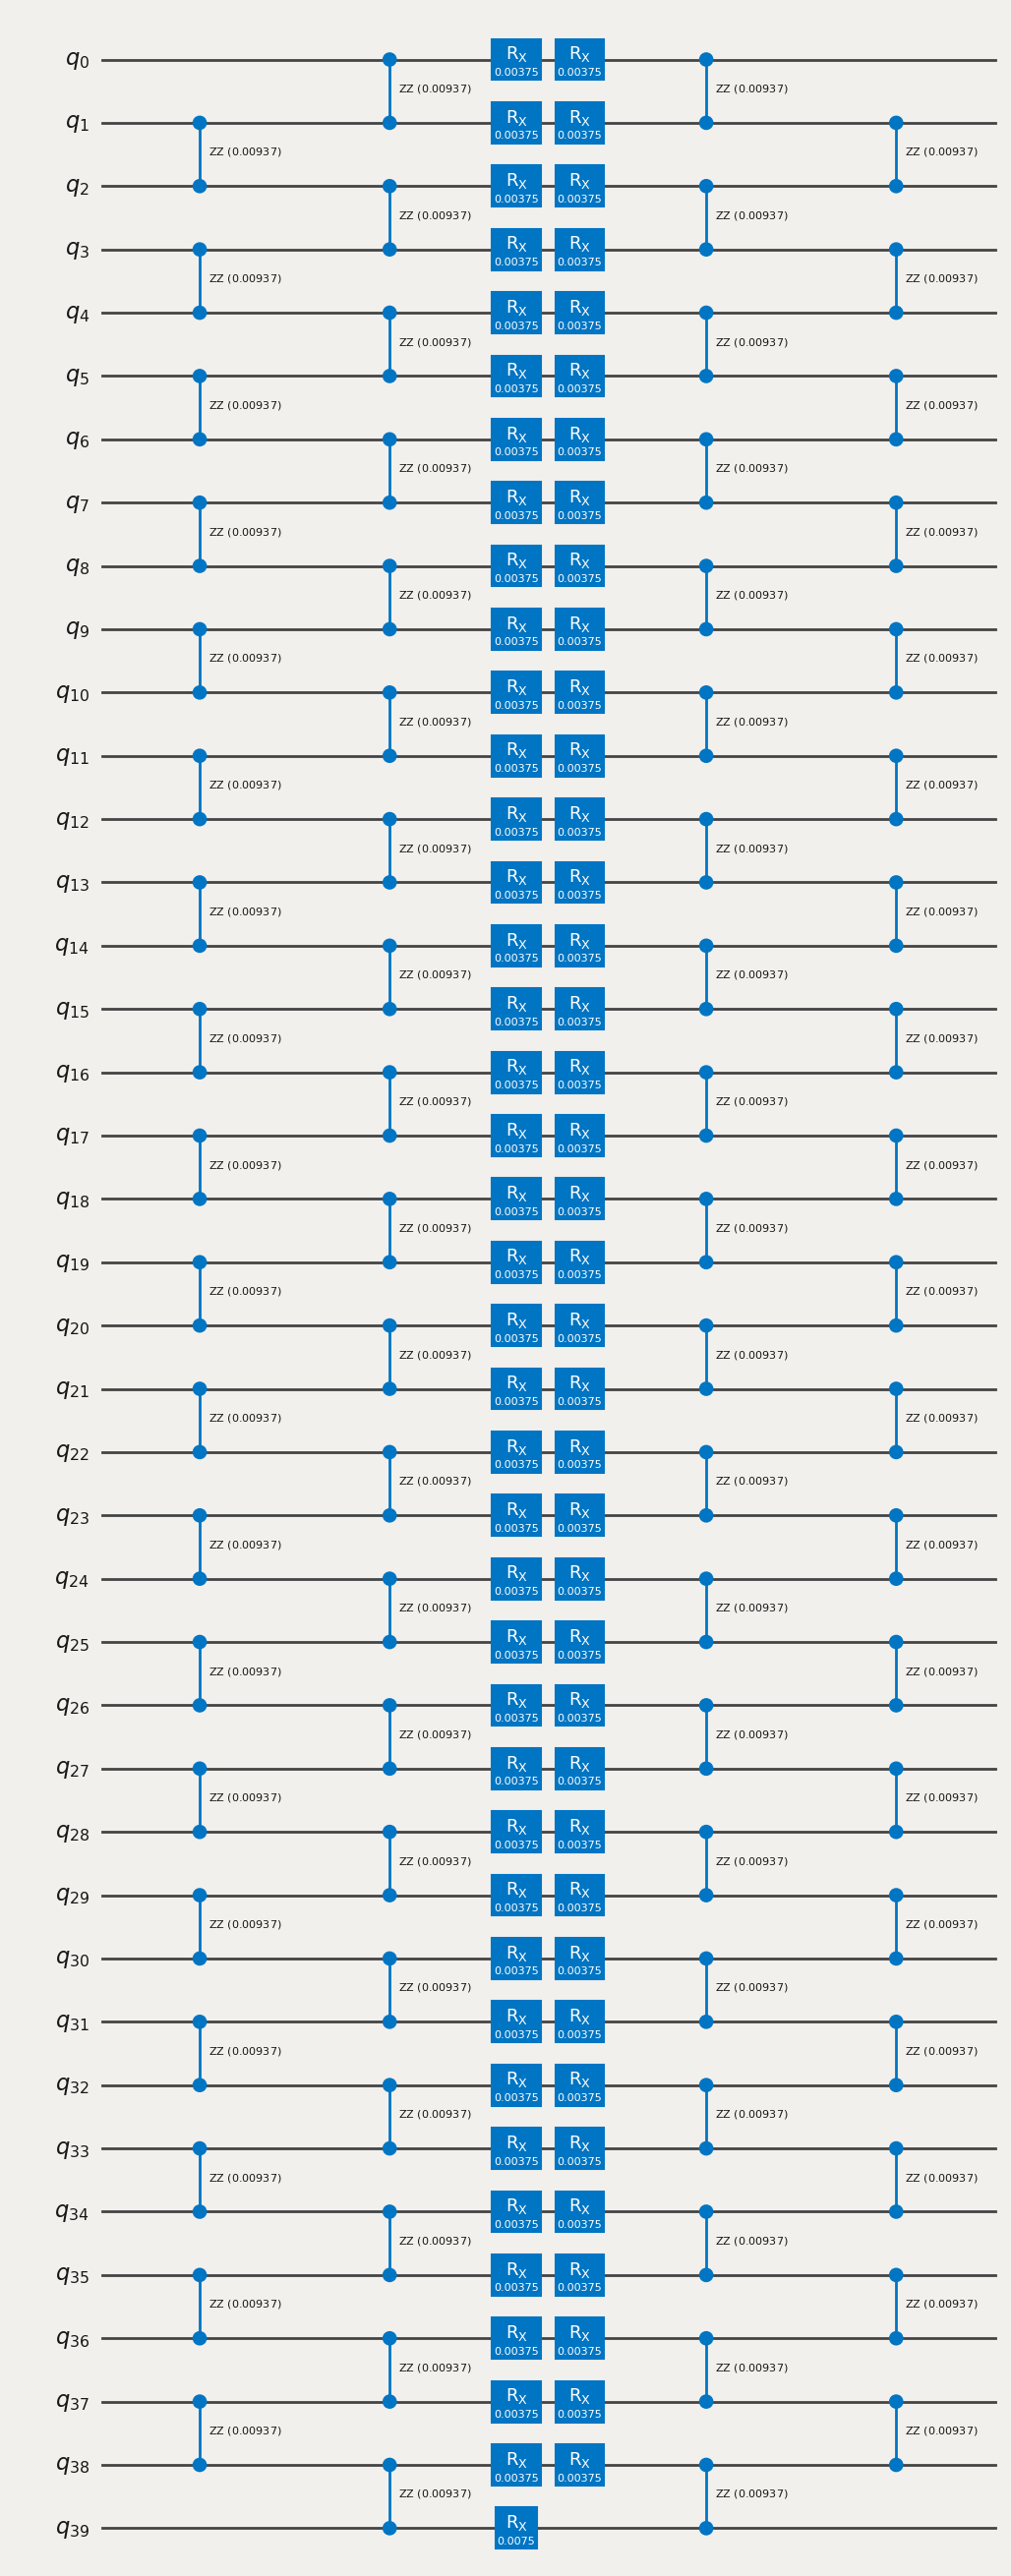

In [3]:
aqc_evolution_time = 2.4
aqc_target_log2_num_trotter_steps = 8

aqc_target_step_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=1),
    time=aqc_evolution_time / 2**aqc_target_log2_num_trotter_steps,
)

print(
    f"This single Trotter step circuit will be repeated {2**aqc_target_log2_num_trotter_steps} times:"
)
aqc_target_step_circuit.draw("mpl", fold=-1)

### Construct a good circuit, with fewer Trotter steps than the target

In [4]:
ansatz_num_trotter_steps = 2

aqc_good_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)

### Generate an ansatz from the good circuit

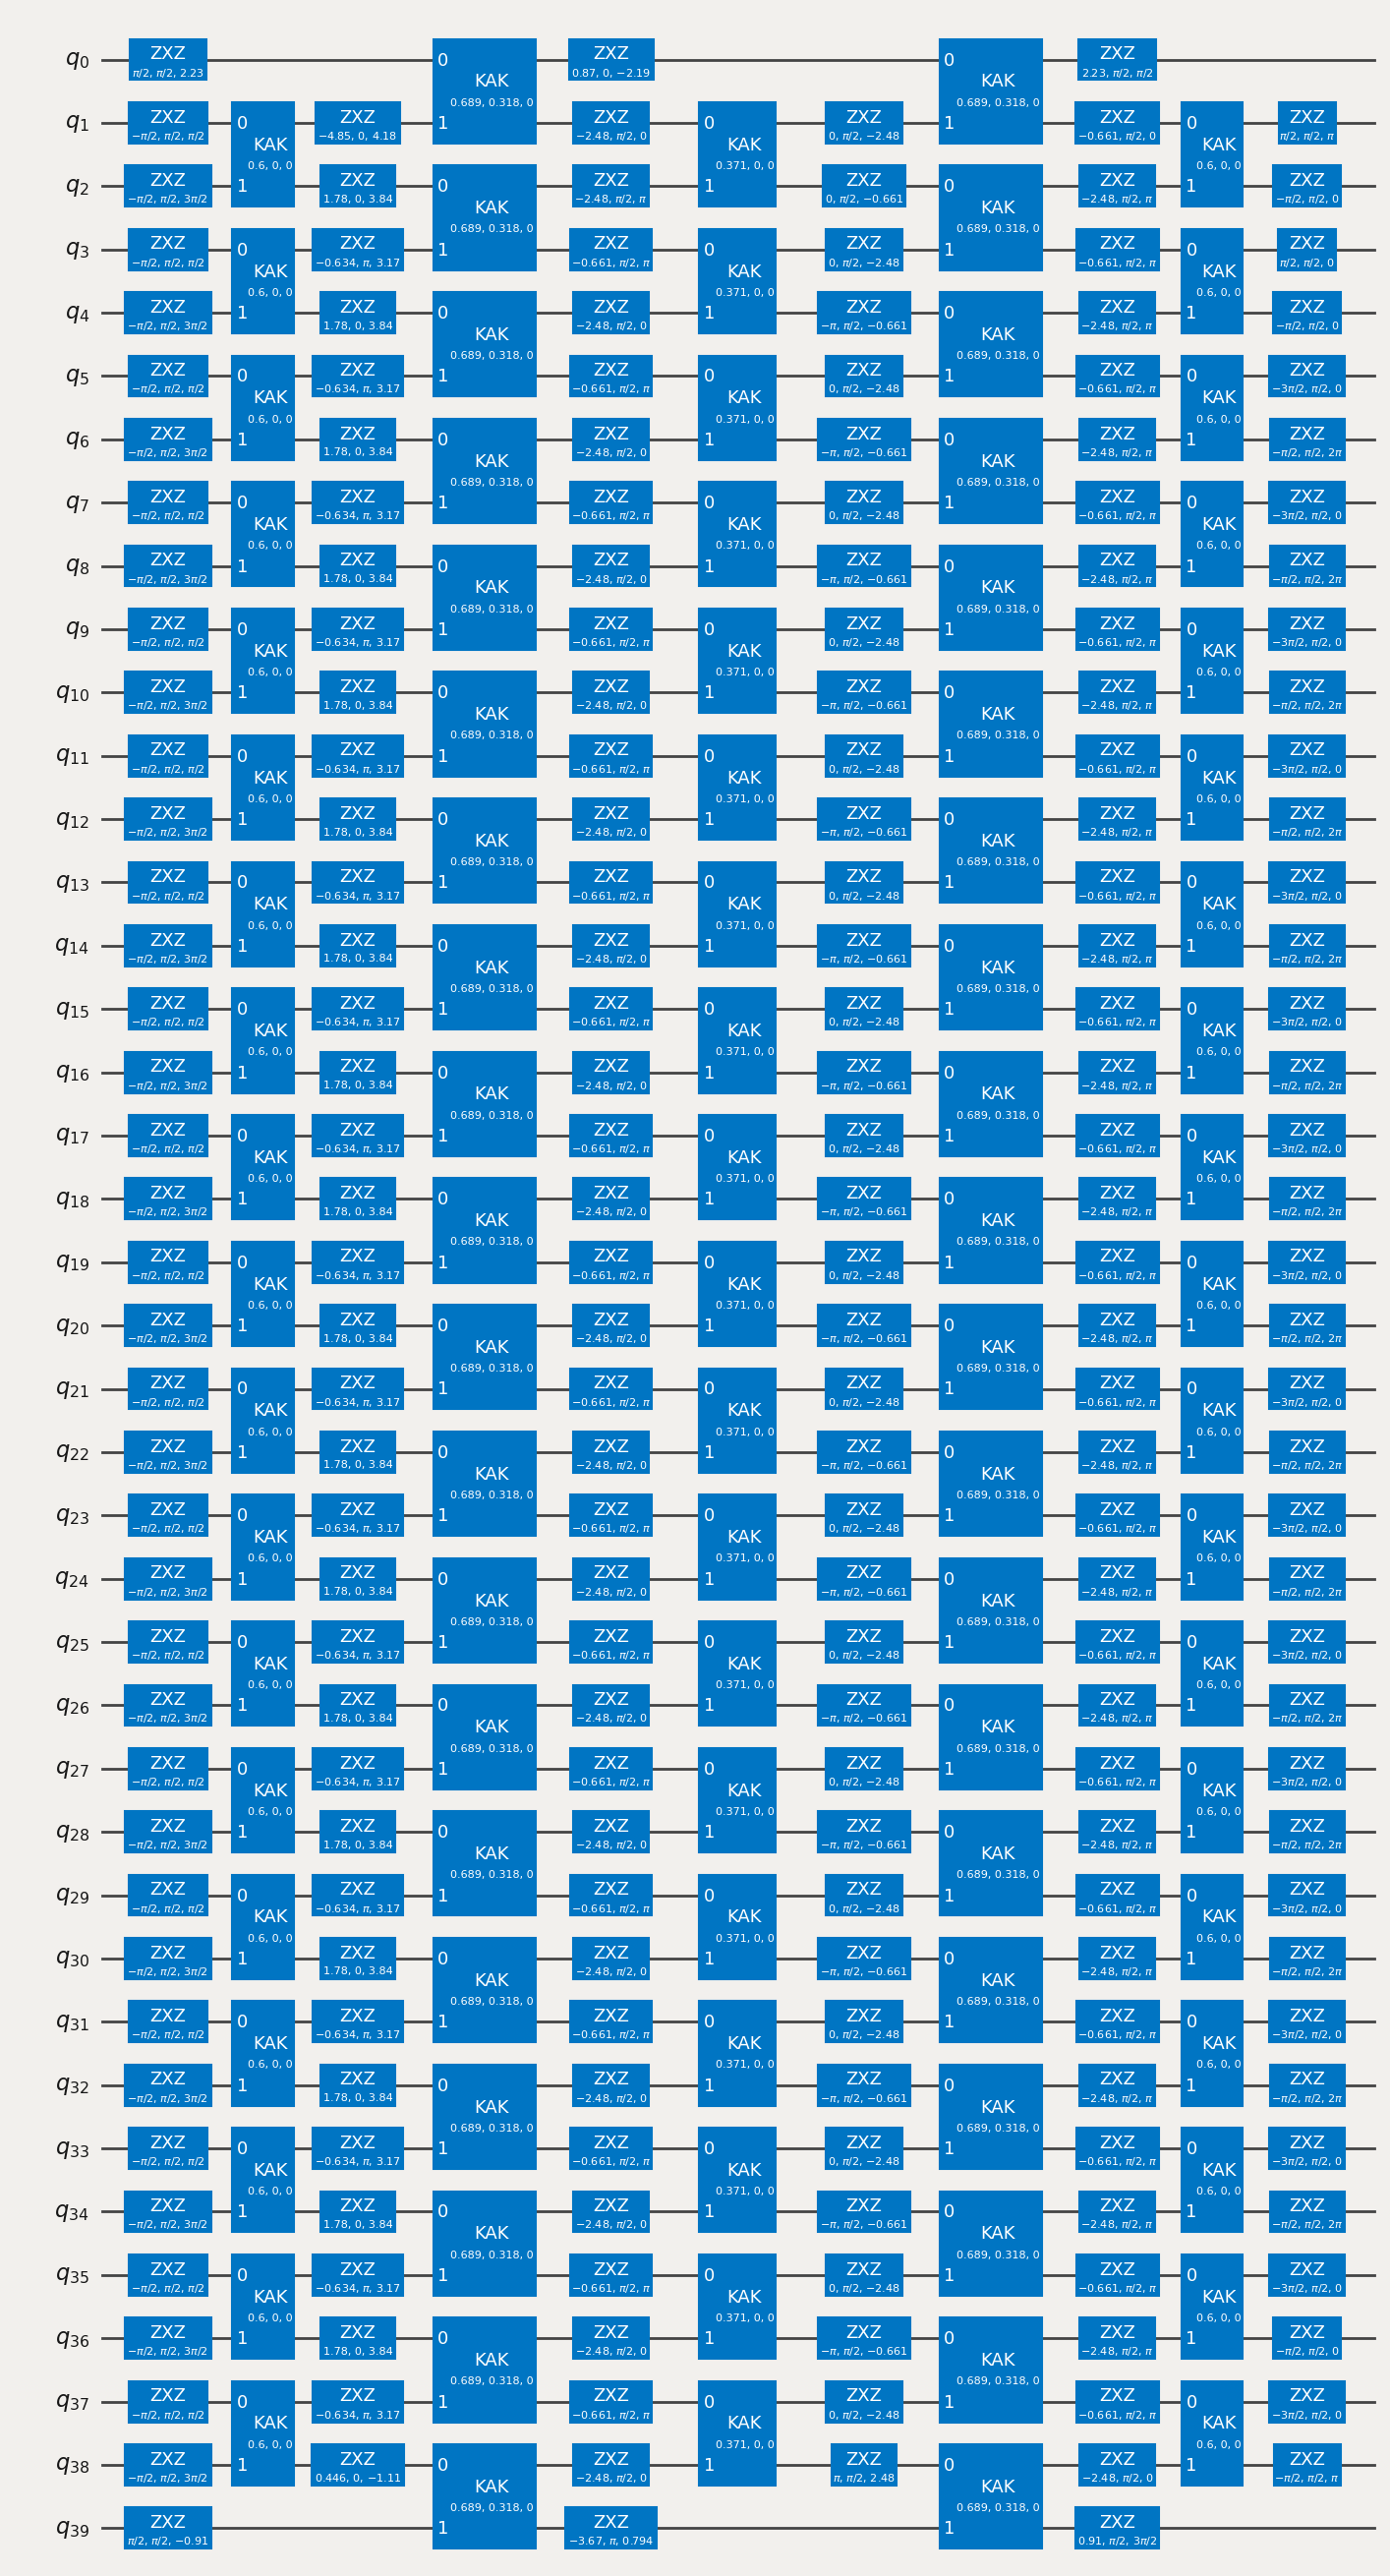

In [5]:
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    aqc_good_circuit, parameter_name="x"
)
aqc_ansatz.assign_parameters(aqc_initial_parameters).draw("mpl", fold=-1)

### Set up quimb

Note that we use `quimb.tensor.Circuit` here, not `CircuitMPS`.

In [6]:
from functools import partial

import quimb.tensor

from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.Circuit, gate_contract="split-gate"),
    autodiff_backend="jax",
)

### Construct target matrix product operator (MPO)

#### Obtain the tensor network of the single Trotter step of the target circuit

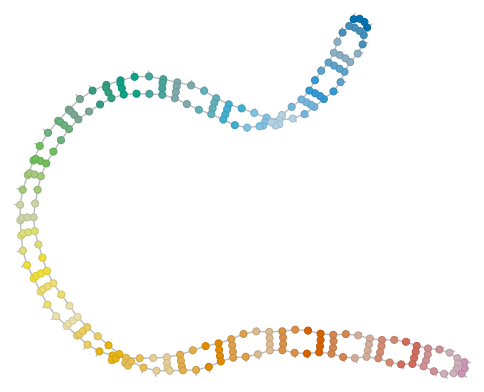

In [16]:
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mpo = tensornetwork_from_circuit(aqc_target_step_circuit, simulator_settings).get_uni()
aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

#### Contract and fuse multibonds to form a matrix-product operator (MPO)

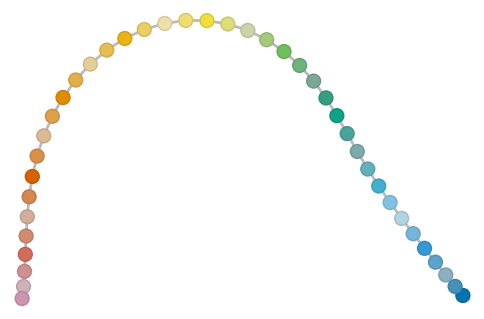

In [8]:
for site in aqc_target_mpo.site_tags:
    aqc_target_mpo.contract(site, inplace=True)
aqc_target_mpo.fuse_multibonds_()

aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

#### Cast it to `quimb.tensor.MatrixProductOperator` and compress

In [9]:
cutoff = 1e-8

aqc_target_mpo.view_as_(
    quimb.tensor.MatrixProductOperator,
    cyclic=False,
    L=coupling_map.num_nodes(),
)
aqc_target_mpo.compress(cutoff=cutoff, create_bond=True)
aqc_target_mpo.show()

│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │


#### Repeatedly square and compress the MPO, so that it represents an operator with many Trotter steps

In [10]:
for _ in range(aqc_target_log2_num_trotter_steps):
    aqc_target_mpo = aqc_target_mpo.apply(aqc_target_mpo)
    aqc_target_mpo.compress(cutoff=cutoff, create_bond=True)
    aqc_target_mpo.show()
aqc_target_mpo

│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│2│
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│3│
●─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<─<
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │ │
│4│4│4│4│4│4│4│4│4│4│4│4│4│4│4│4│4│4│4│4

MatrixProductOperator(tensors=40, indices=119, L=40, max_bond=20)

### Perform optimization using `MaximizeUnitaryFidelity` objective

In [11]:
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

objective = MaximizeUnitaryFidelity(aqc_target_mpo, aqc_ansatz, simulator_settings)

stopping_point = 1e-4


def my_loss_function(*args):
    val, grad = objective.loss_function(*args)
    print(f"Evaluating loss function: {1 - val:.8}")
    return val, grad


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    my_loss_function,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result.message} (status={result.status})")

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Evaluating loss function: 0.0092472409
Evaluating loss function: 0.12156656
Evaluating loss function: 2.6256683e-05
Evaluating loss function: 0.24008339
Evaluating loss function: 0.24196384
Evaluating loss function: 0.24401736
Intermediate result: Fidelity 0.24401736
Evaluating loss function: 0.021325019
Evaluating loss function: 0.24544757
Intermediate result: Fidelity 0.24544757
Evaluating loss function: 0.32001697
Evaluating loss function: 0.59027583
Intermediate result: Fidelity 0.59027583
Evaluating loss function: 0.015687716
Evaluating loss function: 0.67218362
Intermediate result: Fidelity 0.67218362
Evaluating loss function: 0.85221657
Intermediate result: Fidelity 0.85221657
Evaluating loss function: 0.9069756
Intermediate result: Fidelity 0.9069756
Evaluating loss function: 0.94816532
Intermediate result: Fidelity 0.94816532
Evaluating loss function: 0.93650367
Evaluating loss function: 0.95818968
Intermediate result: Fidelity 0.95818968
Evaluating loss function: 0.96186502
I

### Form the optimized circuit

In [12]:
aqc_optimized_block = aqc_ansatz.assign_parameters(aqc_final_parameters)

### Calcuate Frobenius inner product if few qubits

In [13]:
import numpy as np
from qiskit.quantum_info import Operator

if coupling_map.num_nodes() <= 8:
    target_operator = Operator(aqc_target_step_circuit).power(2**aqc_target_log2_num_trotter_steps)

    initial_fidelity = abs(
        np.trace(Operator(aqc_good_circuit).conjugate().to_matrix() @ target_operator.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Initial Frobenius inner product: {initial_fidelity:.8}")

    final_fidelity = abs(
        np.trace(
            Operator(aqc_optimized_block).conjugate().to_matrix() @ target_operator.to_matrix()
        )
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Final Frobenius inner product: {final_fidelity:.8}")

### Form final circuit by repeating the block

The final circuit implements evolution of the Hamiltonian for time = 9.6.


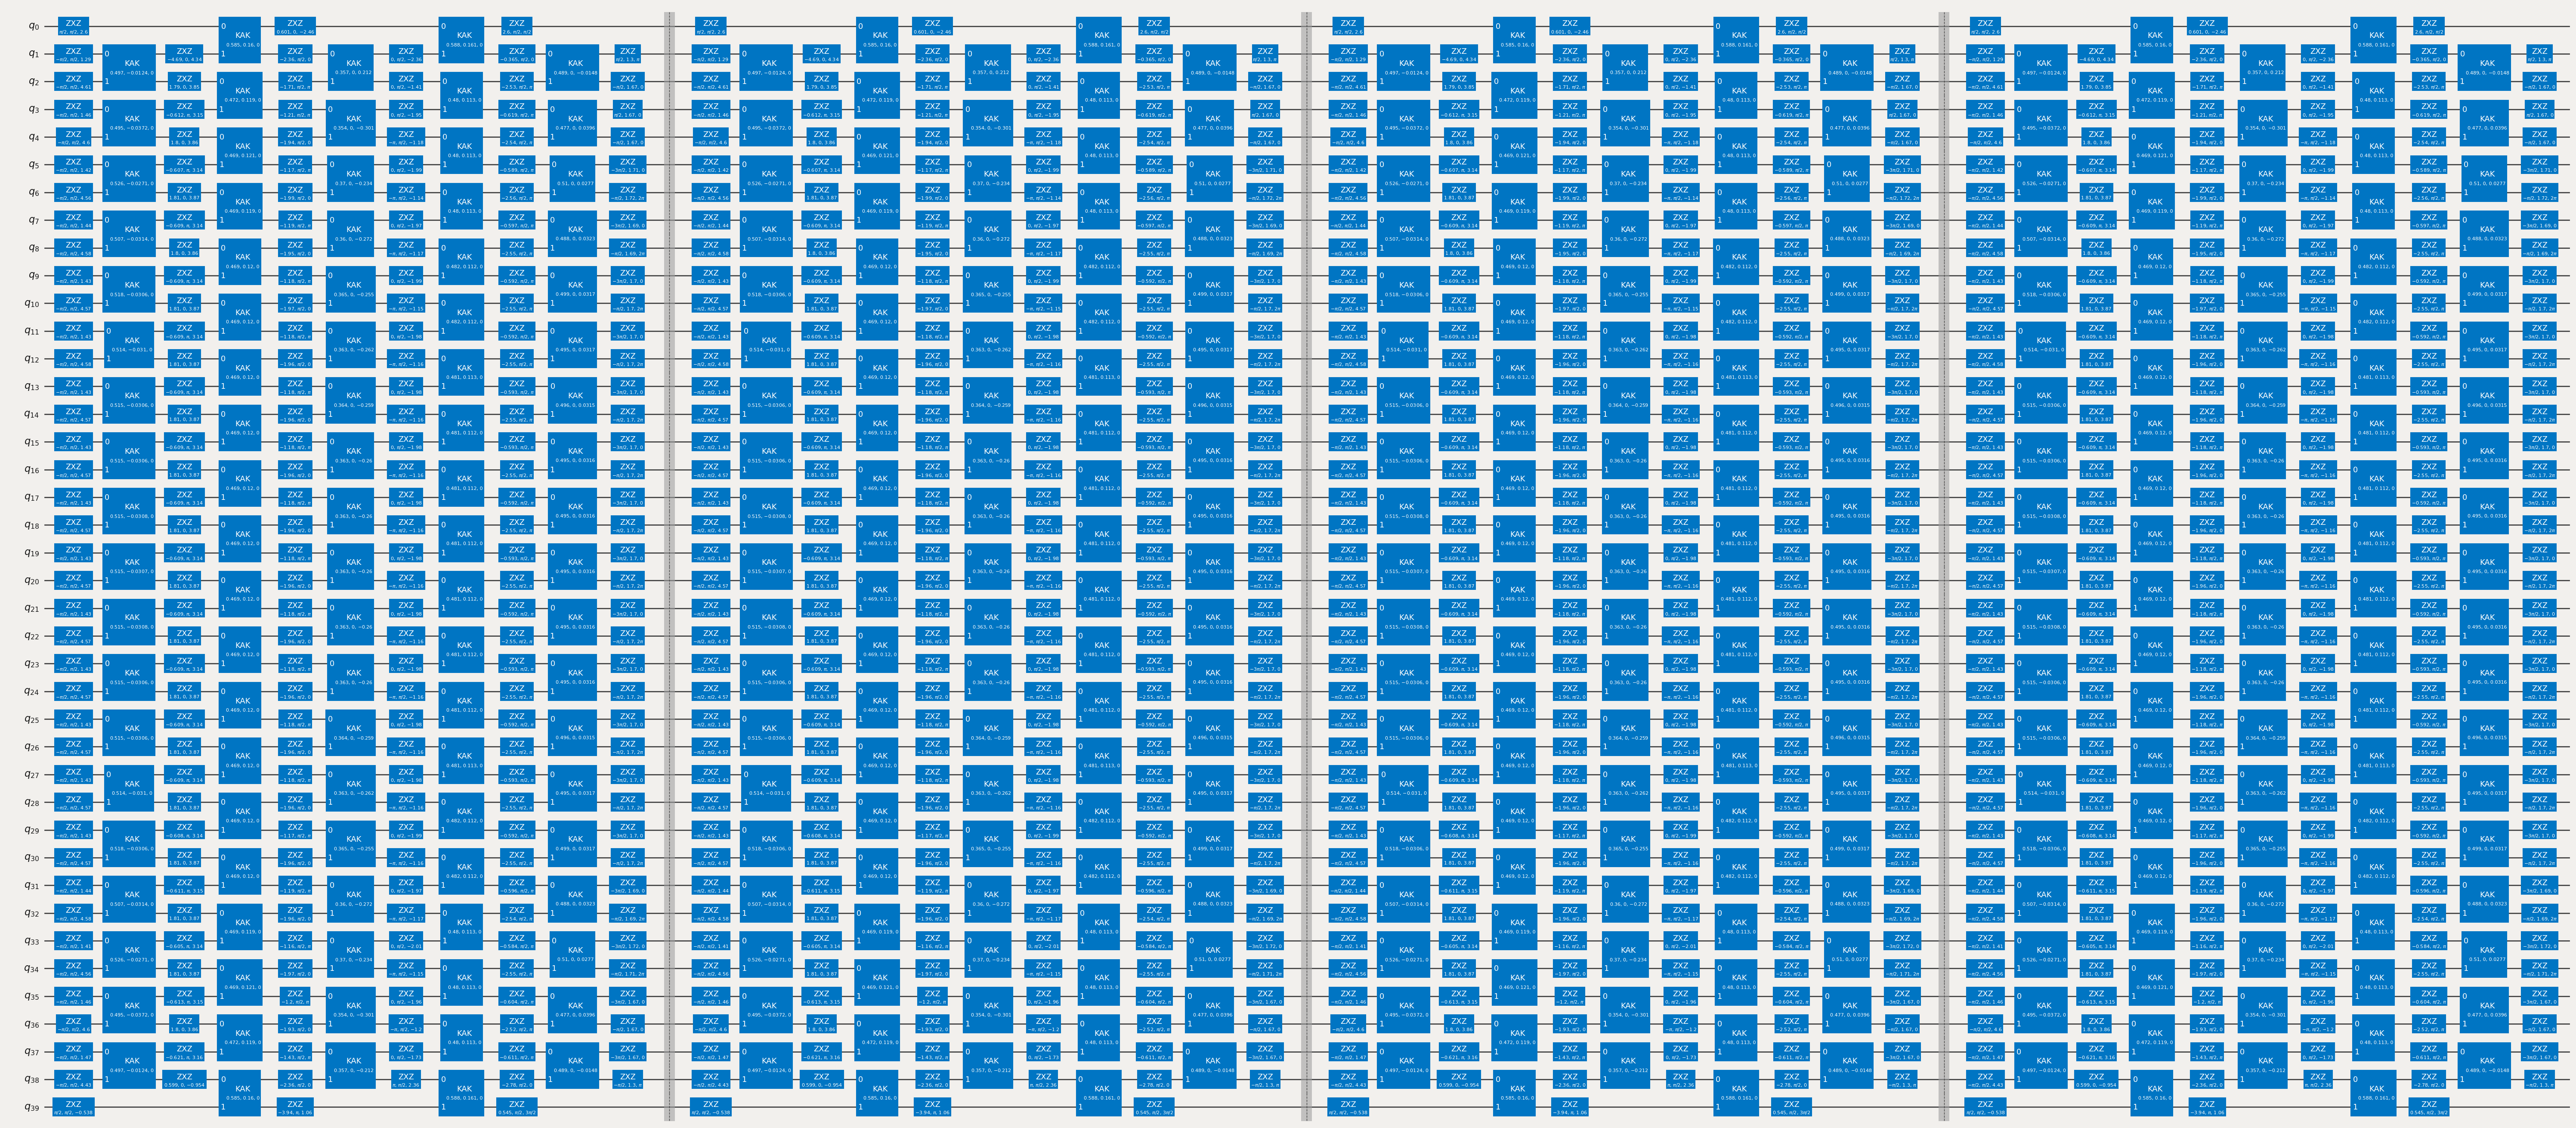

In [14]:
num_repeats = 4

print(
    f"The final circuit implements evolution of the Hamiltonian for time = {num_repeats * aqc_evolution_time}."
)  # FIXME: can i say anything about the fidelity??  ignoring cutoff/roundoff error of course
final_circuit = aqc_optimized_block.repeat(num_repeats)

aqc_optimized_block.repeat(num_repeats, insert_barriers=True).decompose().draw("mpl", fold=-1)

## Step 2: Transpile for execution on target hardware

more to come...